# Problem 0: Metrics vs Loss functions
### As we said in lecture, we optimize (minimize) the loss function, but monitor metrics without letting the model know about their value.

### A very common loss/metric pair is crossentropy for the loss and accuracy for the metric. Often, these two numbers correlate, but they are not guaranteed to do some.

### In this problem, you will come up with 3 sets of 20 synthetic values for predicted probability in a binary classification problem where the crossentropy and accuracy are anti correlated. Plot the loss vs the accuracy.

In [13]:
# safe to restart
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [14]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    num_datapoints = predictions.shape[0]
    ce = -1 * np.sum(targets*np.log(predictions + 1e-9)) / num_datapoints
    return ce

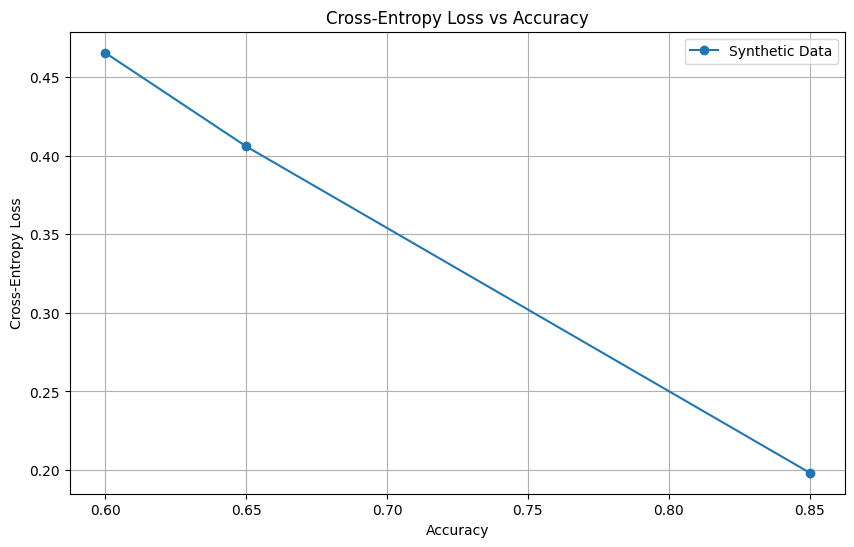

In [15]:
# Hint: not all right and wrong answers are created equally
np.random.seed(42)

y_true = np.random.randint(0, 2, 20)
# print(type(y_true))

# Set 1: High cross-entropy, low accuracy
pred_1 = [0.00, 0.059, 0.693, 0.045, 0.033, 0.966, 0.093, 0.275, 0.187, 0.915, 0.374, 0.019, 0.085, 0.134, 0.792, 0.617, 0.96, 0.736, 0.649, 0.002]
# convert to numpy array
predictions_1 = np.array(pred_1)

# Set 2: Medium cross-entropy, medium accuracy
pred_2 = [0.404, 0.039, 1.0, 0.665, 0.5, 0.469, 0.405, 0.005, 0.872, 0.987, 0.255, 0.389, 0.109, 0.004, 0.097, 0.106, 0.532, 0.406, 0.787, 0.223]
predictions_2 = np.array(pred_2)

# Set 3: Low cross-entropy, high accuracy
pred_3 = [0.015, 0.245, 0.001, 0.827, 0.067, 0.561, 0.903, 0.27, 0.701, 0.966, 0.06, 0.399, 0.883, 0.199, 0.357, 0.15, 0.992, 0.962, 0.002, 0.894]
predictions_3 = np.array(pred_3)

# Calculate cross-entropy and accuracy for each set
ce_1 = cross_entropy(predictions_1, y_true)
acc_1 = accuracy_score(y_true, predictions_1.round())

ce_2 = cross_entropy(predictions_2, y_true)
acc_2 = accuracy_score(y_true, predictions_2.round())

ce_3 = cross_entropy(predictions_3, y_true)
acc_3 = accuracy_score(y_true, predictions_3.round())

# Plotting
cross_entropies = [ce_1, ce_2, ce_3]
accuracies = [acc_1, acc_2, acc_3]

#cross_entropies = [ce_1, ce_2]
#accuracies = [acc_1, acc_2]

plt.figure(figsize=(10, 6))
plt.plot(accuracies, cross_entropies, 'o-', label='Synthetic Data')
plt.xlabel('Accuracy')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss vs Accuracy')

plt.legend()
plt.grid(True)
plt.show()

# Problem 1: Cross Validation


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Part 1: Generate some data
 - Generate data with 1024 points and 10 features.
 - Create targets that are linear combinations of the 10 features and add some noise.
 - Split the data into train/test 80/20 percent.

In [17]:
# Generate some data
# Set a seed for reproducibility
np.random.seed(42)

num_observations = 1024
coefs = np.array([-1.2, 5, 0, .22, 0, 2, 0, 4, 0, 0])  # notice, there are zeros!
noise_amplitude = 5

# num_variables = ...
num_variables = coefs.shape[0]
print(coefs.shape[0])
print(num_variables)

# x = ...
# y = ...
x = np.random.rand(num_observations, num_variables)
y = np.dot(x, coefs) + noise_amplitude * np.random.rand(num_observations)
#print(x)
#print(y)
print(x.shape, y.shape)

# x_train, x_test = ...
# y_train, y_test = ...
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=104, test_size=0.20, shuffle=True) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

del x, y

10
10
(1024, 10) (1024,)
(819, 10) (205, 10) (819,) (205,)


### Part 2: cross validation
Here we will cross validate our data to find the best set of parameters for `Lasso` regression. We will tune the regularization strength (`alpha`) and whether we fit an intercept to the data.
 - For each set of parameters find fit an estimator
 - Calculate the mean squared error on the test set
 - store the results (both the MSE and the parameters) so we can do analysis later

In [18]:
# alphas = # make a list of alphas here
# fit_intercepts = # make a list of the two values for `fit_intercept here`
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_intercept': [True, False]
}

# for all possible combinations, compute necessary metrics
# Initialize the Lasso model
lasso = Lasso()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best MSE: {best_mse}")

# Store the results for analysis
results = pd.DataFrame(grid_search.cv_results_)

Best parameters: {'alpha': 0.1, 'fit_intercept': False}
Best MSE: 2.386309036168309


### Part 3: Analysis
 - for each value of `fit_intercept` plot the `MSE` and `r2` scores as a function of alpha.
 - What is the overall best combination of parameters

In [19]:
# Calculate R2 scores
# Ensure 'mean_test_r2' column is added to the results DataFrame
results['mean_test_r2'] = results.apply(
    lambda row: r2_score(y_test, grid_search.estimator.set_params(**row['params']).fit(X_train, y_train).predict(X_test)),
    axis=1
)

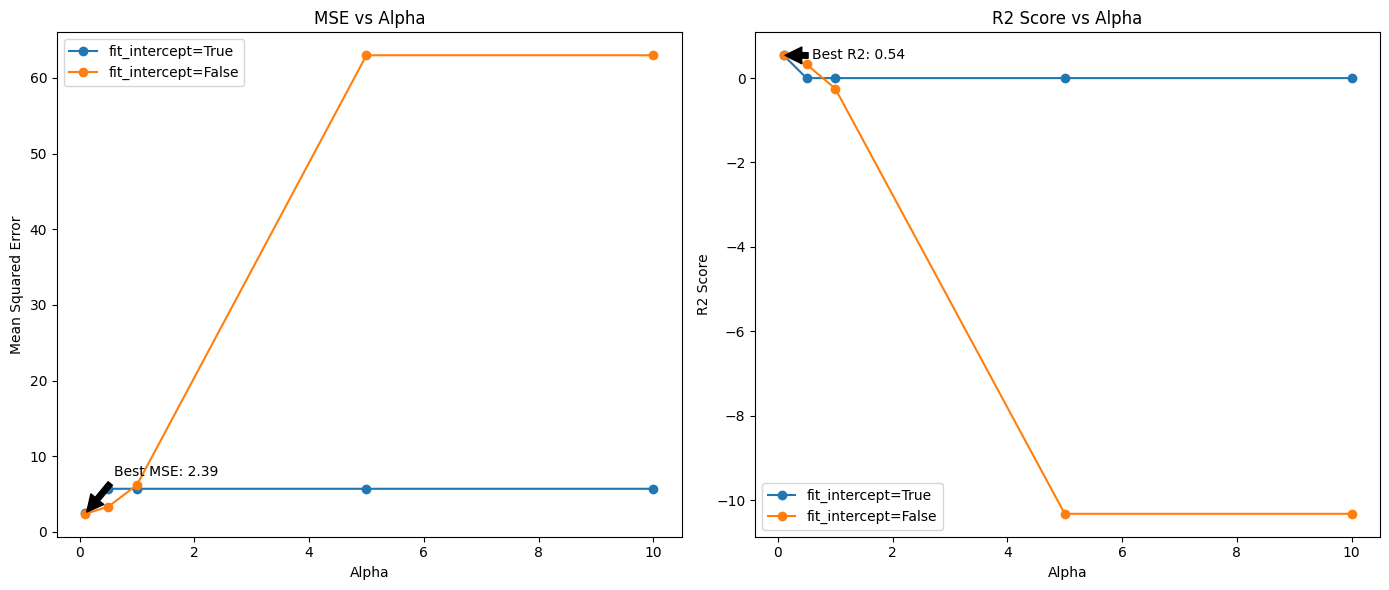

<Figure size 640x480 with 0 Axes>

Overall best parameters: {'alpha': 0.1, 'fit_intercept': False}


In [20]:
# Separate results based on fit_intercept
results_true = results[results['param_fit_intercept'] == True]
results_false = results[results['param_fit_intercept'] == False]

# Plot MSE for each value of fit_intercept
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(results_true['param_alpha'], -results_true['mean_test_score'], label='fit_intercept=True', marker='o')
plt.plot(results_false['param_alpha'], -results_false['mean_test_score'], label='fit_intercept=False', marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.legend()

# Highlight the best MSE
best_mse_row = results.loc[results['mean_test_score'].idxmax()]
plt.annotate(f"Best MSE: {best_mse:.2f}", 
             xy=(best_mse_row['param_alpha'], -best_mse_row['mean_test_score']), 
             xytext=(best_mse_row['param_alpha'] + 0.5, -best_mse_row['mean_test_score'] + 5),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Plot R2 for each value of fit_intercept
plt.subplot(1, 2, 2)
plt.plot(results_true['param_alpha'], results_true['mean_test_r2'], label='fit_intercept=True', marker='o')
plt.plot(results_false['param_alpha'], results_false['mean_test_r2'], label='fit_intercept=False', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Alpha')
plt.legend()

# Highlight the best R2
best_r2_row = results.loc[results['mean_test_r2'].idxmax()]
plt.annotate(f"Best R2: {best_r2_row['mean_test_r2']:.2f}", 
             xy=(best_r2_row['param_alpha'], best_r2_row['mean_test_r2']), 
             xytext=(best_r2_row['param_alpha'] + 0.5, best_r2_row['mean_test_r2'] - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# Overall best combination of parameters
print(f"Overall best parameters: {best_params}")

# Problem 2: Linear regression in Keras (40%)

#### We'd like to use keras to perform linear regression and compare it to another tool (scikit-learn)
#### We'll compare OLS, ridge ($L2$ regularization) and LASSO ($L1$ regularization) using both keras and scikit-learn


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [22]:
# Set seed for reproducibility
np.random.seed(42)

# Generate some data
num_observations = 1024
coefs = np.array([-1.2, 5, 0, .22, 2, 0, 4])  # notice, there are zeros!
noise_amplitude = 0.05

num_variables = coefs.shape[0]
print(num_variables)

x = np.random.rand(num_observations, num_variables)
y = np.dot(x, coefs) + noise_amplitude * np.random.rand(num_observations)
print(x.shape, y.shape)

# your code here,
# split data into x_train, x_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=104, test_size=0.20, shuffle=True) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

7
(1024, 7) (1024,)
(819, 7) (205, 7) (819,) (205,)


In [23]:
# fit linear regression here and calculate MSE
# put code here
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

Mean Squared Error: 0.00021341450952880355
R2 Score: 0.9999443773039971


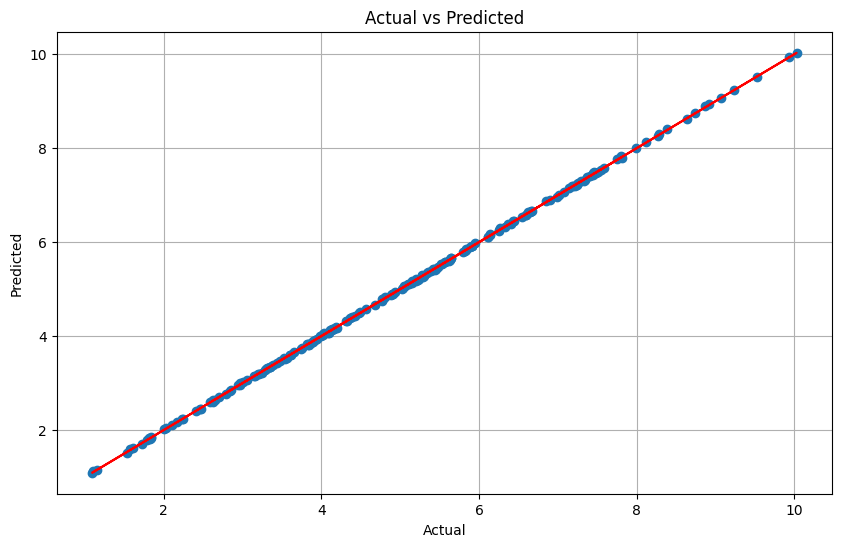

In [24]:
# Plot the regression model
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred, 'o')
plt.plot(y_test, y_test, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

In [25]:
# Show that the coefficients are all close the "real" ones used to generate the data
# put code here
# Compare the coefficients
comparison_df = pd.DataFrame({
    'Real Coefficients': coefs,
    'Estimated Coefficients': model.coef_
})

print(comparison_df)

   Real Coefficients  Estimated Coefficients
0              -1.20               -1.196851
1               5.00                4.998802
2               0.00               -0.000282
3               0.22                0.219843
4               2.00                2.000461
5               0.00               -0.000207
6               4.00                4.000707


In [11]:
# from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras import backend as K

# def plot_model_in_notebook(model):
    # return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='png'))

In [26]:
K.clear_session()
# Now we will use keras to solve the same problem
#input_data = Input(shape=FIXME)
inputs = Input(shape=(X_train.shape[1],))
print(X_train.shape[1])
print(inputs)

# add model definition here
# build model here
#keras_lin_reg = Model(...)
keras_lin_reg = Sequential()
keras_lin_reg.add(inputs)
keras_lin_reg.add(Dense(1, activation='linear'))
# keras_lin_reg.add(Dense(units=1, input_shape=(X_train.shape[1],), activation='linear'))
keras_lin_reg.summary()

7
<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (32.00 B)

 Trainable params: 8 (32.00 B)

 Non-trainable params: 0 (0.00 B)

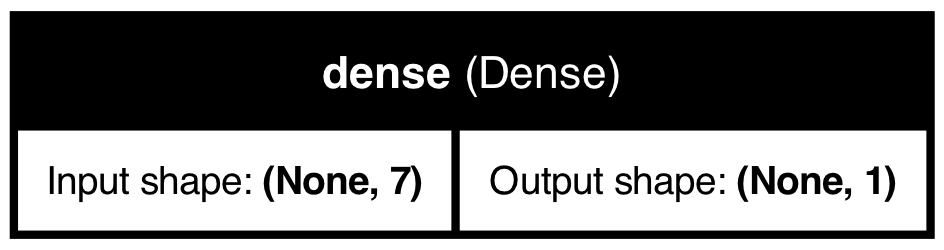

In [27]:
# don't forget to compile model here
keras_lin_reg.compile(optimizer=Adam(), loss='mean_squared_error')
# keras_lin_reg.summary()

# plot the model
from IPython.display import Image
from keras.utils import plot_model
import pydot

plot_model(keras_lin_reg, show_shapes=True, show_layer_names=True, to_file='keras_lin_model.png')
Image('keras_lin_model.png')


## How many parameters does the model have?
### Explicitly show the calculation, explain it, and verify that it agrees with `model.count_params()`

In [28]:
# Calculate the number of parameters explicitly
input_shape = X_train.shape[1]
output_shape = 1
num_weights = input_shape * output_shape
num_biases = output_shape
total_params = num_weights + num_biases

print(f"Calculated number of parameters: {total_params}")

# Verify with model.count_params()
print(f"Number of parameters from model.count_params(): {keras_lin_reg.count_params()}")

Calculated number of parameters: 8
Number of parameters from model.count_params(): 8


## Fit the model and calculate the MSE

### Find the optimal hyperparameters

In [32]:
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor

# Wrap the Keras model with KerasClassifier
keras_model = KerasClassifier(model=keras_lin_reg, verbose=0)

# Define the grid search parameters
param_grid = {
    'epochs': [25, 50, 100, 200, 300, 400],
    'batch_size': [12, 24, 36, 48]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best MSE: {best_mse}")

ModuleNotFoundError: No module named 'scikeras'

In [434]:
# Fit the model
history = keras_lin_reg.fit(X_train, y_train, epochs=400, batch_size= 25, verbose=0)

# Predict on the test set
y_pred_keras = keras_lin_reg.predict(X_test)

# Calculate the Mean Squared Error
mse_keras = mean_squared_error(y_test, y_pred_keras)
print(f"Mean Squared Error (Keras): {mse_keras}")

# Calculate the R2 score
r2_keras = r2_score(y_test, y_pred_keras)
print(f"R2 Score (Keras): {r2_keras}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (Keras): 0.00021901220405059655
R2 Score (Keras): 0.9999429183644836


## get the coefficients and compare them to the real coefficients

In [435]:
# Get the coefficients from the Keras model
keras_coefs_lin = keras_lin_reg.layers[0].get_weights()[0].flatten()

# Compare the coefficients
comparison_df_lin = pd.DataFrame({
    'Real Coefficients': coefs,
    'Keras Coefficients': keras_coefs_lin
})

print(comparison_df_lin)

# 

   Real Coefficients  Keras Coefficients
0              -1.20           -1.201063
1               5.00            4.993067
2               0.00           -0.004784
3               0.22            0.215908
4               2.00            1.995804
5               0.00           -0.004356
6               4.00            3.995818


## Now we will add some regularization

In [436]:
# K.clear_session()
from tensorflow.keras.regularizers import l1_l2
ridge_regularizer = l1_l2(l1=0, l2=.1)
 # Dense(...) -> Dense(..., kernel_regularizer=regularizer)
#keras_ridge_model = Model(...

# Create the model
keras_ridge_model = Sequential()
keras_ridge_model.add(inputs)
keras_ridge_model.add(Dense(1, activation='linear', kernel_regularizer=ridge_regularizer))
# keras_ridge_model.add(Dense(units=1, input_shape=(X_train.shape[1],), activation='linear', kernel_regularizer=regularizer))

# Compile the model
keras_ridge_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Display the model summary
keras_ridge_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (32.00 B)

 Trainable params: 8 (32.00 B)

 Non-trainable params: 0 (0.00 B)

In [437]:
# fit the model and calculate the MSE
#mean_squared_error(...
# Fit the model
history_ridge = keras_ridge_model.fit(X_train, y_train, epochs=400, batch_size=25, verbose=0)

# Predict on the test set
y_pred_keras_ridge = keras_ridge_model.predict(X_test)

# Calculate the Mean Squared Error
mse_keras_ridge = mean_squared_error(y_test, y_pred_keras_ridge)
print(f"Mean Squared Error (Keras - Ridge): {mse_keras_ridge}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (Keras - Ridge): 1.1631356030297428


In [438]:
# find the coefficients and compare them to the real ones
# keras_ridge_coefs = ....

# Get the coefficients from the Keras model
keras_ridge_coefs = keras_ridge_model.layers[0].get_weights()[0].flatten()

# Compare the coefficients
comparison_df_ridge_keras = pd.DataFrame({
    'Real Coefficients': coefs,
    'Keras Ridge Coefficients': keras_ridge_coefs
})

print(comparison_df_ridge_keras)

# pd.Series(keras_ridge_coefs, name='keras ridge coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

   Real Coefficients  Keras Ridge Coefficients
0              -1.20                 -0.492042
1               5.00                  2.243809
2               0.00                 -0.014456
3               0.22                  0.071434
4               2.00                  0.936855
5               0.00                  0.047027
6               4.00                  1.801457


In [439]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=.1)
ridge.fit(X_train, y_train)
pd.Series(ridge.coef_, name='ridge coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,ridge coefficients,real coefficients
0,-1.194915,-1.20
1,4.991182,5.00
2,-0.000508,0.00
3,0.219223,0.22
4,1.997556,2.00
5,-0.000030,0.00
6,3.994604,4.00


In [440]:
# compare coefficients from various methods
pd.concat([
    pd.Series(ridge.coef_, name='ridge coefs'),
    pd.Series(keras_ridge_coefs, name='keras L2 coefs'),
    pd.Series(coefs, name='real coefs')
], axis=1)

,ridge coefs,keras L2 coefs,real coefs
0,-1.194915,-0.492042,-1.20
1,4.991182,2.243809,5.00
2,-0.000508,-0.014456,0.00
3,0.219223,0.071434,0.22
4,1.997556,0.936855,2.00
5,-0.000030,0.047027,0.00
6,3.994604,1.801457,4.00


## In fact, given the zero coefficients, LASSO might have been a better model.
## LASSO uses $L_{1}$ regularization which will make sparse coefficients (some are zero).

In [441]:
from sklearn.linear_model import Lasso

# Initialize the Lasso model with a chosen alpha value
lasso_model = Lasso(alpha=0.1)

# Fit the model to the training data
lasso_model.fit(X_train, y_train)

# Store the coefficients
lasso_coefs = lasso_model.coef_

pd.Series(lasso_coefs, name='lasso coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,lasso coefficients,real coefficients
0,-0.000000,-1.20
1,3.717046,5.00
2,-0.000000,0.00
3,0.000000,0.22
4,0.795722,2.00
5,0.000000,0.00
6,2.766542,4.00


In [442]:
# Clear previous session
# K.clear_session()

lasso_regularizer = l1_l2(l1=0.1, l2=0)

# Create the LASSO model
keras_lasso_model = Sequential()
keras_lasso_model.add(inputs)
keras_lasso_model.add(Dense(1, activation='linear', kernel_regularizer=lasso_regularizer))
# keras_lasso_model.add(Dense(units=1, input_shape=(X_train.shape[1],), activation='linear', kernel_regularizer=lasso_regularizer))

# Compile the model
keras_lasso_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Display the model summary
keras_lasso_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (32.00 B)

 Trainable params: 8 (32.00 B)

 Non-trainable params: 0 (0.00 B)

In [443]:
#keras_lasso_coefs = ...
# Fit the model
history_lasso = keras_lasso_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the test set
y_pred_keras_lasso = keras_lasso_model.predict(X_test)

# Calculate the Mean Squared Error
mse_keras_lasso = mean_squared_error(y_test, y_pred_keras_lasso)
print(f"Mean Squared Error (Keras - LASSO): {mse_keras_lasso}")

# Get the coefficients from the Keras model
keras_lasso_coefs = keras_lasso_model.layers[0].get_weights()[0].flatten()

# Compare the coefficients
comparison_df_lasso_keras = pd.DataFrame({
    'Real Coefficients': coefs,
    'Keras LASSO Coefficients': keras_lasso_coefs
})

print(comparison_df_lasso_keras)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (Keras - LASSO): 3.1330744891775337
   Real Coefficients  Keras LASSO Coefficients
0              -1.20                  0.858343
1               5.00                  1.125478
2               0.00                  1.081878
3               0.22                  1.227115
4               2.00                  1.384926
5               0.00                  1.413826
6               4.00                  0.629488


In [444]:
# compare all the coefficients
pd.concat([
    pd.Series(coefs, name='real coefs'),
    pd.Series(model.coef_, name='ols coefs'),
    pd.Series(ridge.coef_, name='ridge coefs'),
    pd.Series(keras_ridge_coefs, name='keras L2 coefs'),
    pd.Series(lasso_model.coef_, name='lasso coefs'),
    pd.Series(keras_lasso_coefs, name='keras L1 coefs'),
], axis=1)

,real coefs,ols coefs,ridge coefs,keras L2 coefs,lasso coefs,keras L1 coefs
0,-1.20,-1.196851,-1.194915,-0.492042,-0.000000,0.858343
1,5.00,4.998802,4.991182,2.243809,3.717046,1.125478
2,0.00,-0.000282,-0.000508,-0.014456,-0.000000,1.081878
3,0.22,0.219843,0.219223,0.071434,0.000000,1.227115
4,2.00,2.000461,1.997556,0.936855,0.795722,1.384926
5,0.00,-0.000207,-0.000030,0.047027,0.000000,1.413826
6,4.00,4.000707,3.994604,1.801457,2.766542,0.629488


## Comment on the results

TBD

# Problem 3: Custom Loss Functions
### In this problem we will explore the use of custom loss function to better capture desired behavior in a model.
### In particular, we will examine the tradeoff between false positives and true positives

In [188]:
import numpy as np
import pandas as pd
%pylab inline

# many of these to be removed
# Insert necessary imports here
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Part 0: Data preparation
 - ### Load the `mnist` data and subset the data only to the classes `4` and `9`
 - ### This way we have a binary classification task for simplicity

In [446]:

def preprocess_training_data(data):
    data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    data = data.astype('float32') / 255
    return data

def preprocess_targets(target, num_classes):
    return to_categorical(target, num_classes)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess_training_data(x_train)
x_test = preprocess_training_data(x_test)

num_classes = np.unique(y_train).shape[0]

y_train_ohe = preprocess_targets(y_train, num_classes)
y_test_ohe = preprocess_targets(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

# get type of x_train and y_train
print(type(x_train))
print(type(y_train))

(60000, 784)
(60000,)
(10000, 784)
(10000,)
(60000, 10)
(10000, 10)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Filter for 4 and 9

In [447]:
def subset_to_9_and_4(x, y):  # this is a new function
    # insert code here:
    # Create a boolean mask for values of y that are either 4 or 9
    mask = np.isin(y, [4, 9])
    
    # new_x should be x where y is either 4 or 9
    new_x = x[mask]
    
    # new_y should be True if y == 4 and False if y == 9
    new_y = (y[mask] == 4)
    
    return new_x, new_y

x_train, y_train = subset_to_9_and_4(x_train, y_train)
x_test, y_test = subset_to_9_and_4(x_test, y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# convert y_train to dataframe for testing
y_train_df = pd.DataFrame(y_train)
y_train_df.head()

(11791, 784)
(11791,)
(1991, 784)
(1991,)


,0
0,True
1,False
2,True
3,False
4,True


## Part 1: fit logistic regression in `scikit-learn` and compute the true positive and false positive rates

In [448]:
%%time
# insert code here

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [449]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Predict on test set
y_pred_log_reg = log_reg.predict(x_test)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log_reg).ravel()

# Calculate true positive rate, false positive, and false negative rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print('True Positive Rate (TPR): {:.3f}'.format(tpr))
print('False Positive Rate (FPR): {:.3f}'.format(fpr))
print('False Negative Rate (FNR): {:.3f}'.format(fnr))

True Positive Rate (TPR): 0.974
False Positive Rate (FPR): 0.029
False Negative Rate (FNR): 0.026


/Users/bluebird/.pyenv/versions/3.10.11/envs/venv310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Part 2: A custom loss function
Write a function that returns a custom loss function.<br>
As a shortcut, we can modify the loss function to be
$J(\theta )$=`regular crossentropy `  $\times$  $\alpha$

where
 - $\alpha=$ 1 + `weight_factor` (a number greater than 0) for the positive class (`y=1`)
 - $\alpha=$ `1` for the negative class (`y=0`)

Like this we can over weight how much we care about positive examples.

$ \\ $
Function
Inputs:
 - `weight_factor`: the multiplicative factor for how much to weight errors in the `1` class over `0`

Output:
 - a function that has inputs `(y_true, y_pred)` that is a viable keras loss function.


In [193]:
import tensorflow as tf

def get_loss_function(weight_factor):
    def my_cross_entropy(y_true, y_pred):
        # Calculate the regular cross-entropy loss
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # Calculate the weights: 1 + weight_factor for positive class, 1 for negative class
        weights = 1 + weight_factor * y_true
        
        # Apply the weights to the cross-entropy loss
        weighted_loss = cross_entropy_loss * weights
        
        # Return the mean loss
        return tf.reduce_mean(weighted_loss)
    
    return my_cross_entropy

## Part 3: Fit Models with Different `weight_factors`
Steps
 - For values in `np.linspace(0, 20, 50)` fit logistic regression in keras.
 - For each model compute the true positive and false positive rate
 - Make a plot of true positives and false positives as a function of `weight_factor`
 - Make a plot of true positives as a function of false positives

In [194]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

# Function to create and compile a logistic regression model with a custom loss function
def create_model(weight_factor):
    model = Sequential()
    digit_input = Input(shape=(x_train.shape[1],), name='digit_input')
    model.add(digit_input)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss=get_loss_function(weight_factor))
    return model

# Dictionary to store results
res = {'weight_factor': [], 'tpr': [], 'fpr': []}

# Fit models with different weight factors and compute metrics
for wt in np.linspace(0, 20, 50):
    model = create_model(wt)
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    y_pred_keras = model.predict(x_test).round()
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_keras).ravel()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    res['weight_factor'].append(wt)
    res['tpr'].append(tpr)
    res['fpr'].append(fpr)

# Convert results to DataFrame for plotting
res_df = pd.DataFrame(res)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


KeyboardInterrupt: 

In [195]:
res_df.head()

,weight_factor,tpr,fpr
0,0.000000,0.974542,0.024777
1,0.408163,0.977597,0.026759
2,0.816327,0.976578,0.026759
3,1.224490,0.978615,0.026759
4,1.632653,0.977597,0.026759


In [196]:
# Show row where the fpr is the lowest
res_df.loc[res_df['fpr'].idxmin()]

weight_factor    2.857143
tpr              0.973523
fpr              0.017839
Name: 7, dtype: float64

In [197]:
# Show row where the tpr is the highest
res_df.loc[res_df['tpr'].idxmax()]

weight_factor    12.653061
tpr               0.980652
fpr               0.026759
Name: 31, dtype: float64

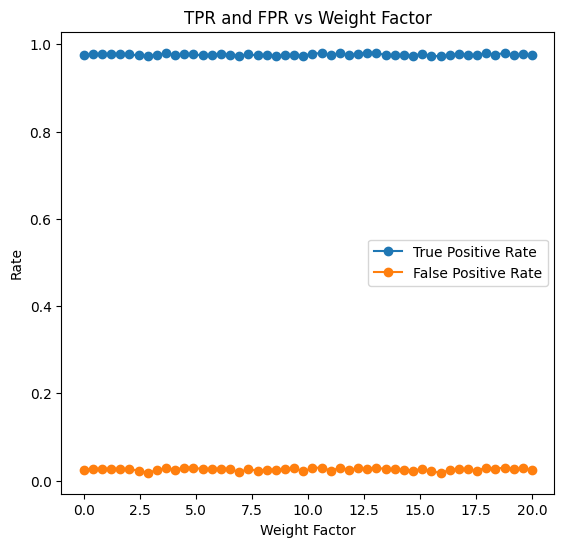

In [198]:
# put plotting code here
# true positive and false positives as a function of wt
# Plot true positives and false positives as a function of weight_factor
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(res_df['weight_factor'], res_df['tpr'], label='True Positive Rate', marker='o')
plt.plot(res_df['weight_factor'], res_df['fpr'], label='False Positive Rate', marker='o')
plt.xlabel('Weight Factor')
plt.ylabel('Rate')
plt.title('TPR and FPR vs Weight Factor')
plt.legend()

# Export plot to file
plt.savefig('tpr_fpr_vs_weight_factor.png')

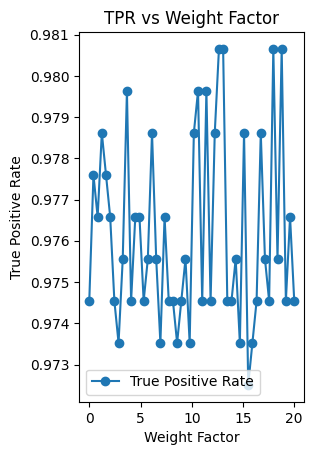

In [450]:
# Graph the true positive rate against the weight factor
plt.subplot(1, 2, 2)
plt.plot(res_df['weight_factor'], res_df['tpr'], label='True Positive Rate', marker='o')
plt.xlabel('Weight Factor')
plt.ylabel('True Positive Rate')
plt.title('TPR vs Weight Factor')
plt.legend()
plt.show()


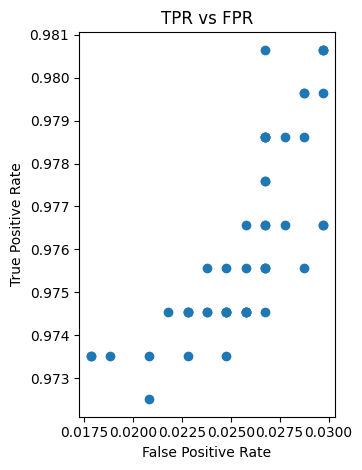

<Figure size 640x480 with 0 Axes>

In [451]:
# true positives as a function of false positives
# Plot true positives as a function of false positives
plt.subplot(1, 2, 2)
plt.plot(res_df['fpr'], res_df['tpr'], marker='o', linewidth=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TPR vs FPR')

plt.tight_layout()
plt.show()

# Export plot to file
plt.savefig('tpr_vs_fpr.png')

## Part 4: Thresholding vs Loss Function
What is the difference between using regular crossentropy and changing thresholds vs changing the loss function?<br>
Typically, we consider anything with a predicted probability of 0.5 or above to be a positive example. What if we change this number?

Steps:
 - Fit logistic regression in keras with the regular (crossentropy) loss function
 - Find the false positive and true positive rates as a function of the `threshold` for which we consider a positive example.
 - Make a plot of false positives as a function of true positives for this thresholding method.
 - On the same axes, plot the old curve of false positives as a function of true positives
 - Comment on what you find- what are the advantages and disadvantages of these two methods.

In [200]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [201]:
#K.clear_session()
# Fit logistic regression in keras with the regular (crossentropy) loss function
def create_logistic_regression_model():
    model = Sequential()
    digit_input = Input(shape=(x_train.shape[1],), name='digit_input')
    model.add(digit_input)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

# Create and fit the model
logistic_regression_model = create_logistic_regression_model()
logistic_regression_model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
logistic_regression_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,357 (9.21 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,572 (6.14 KB)

In [452]:
#pred_proba = model.predict(x_test)
# Predict probabilities on the test set
y_pred_proba = logistic_regression_model.predict(x_test)

# Function to calculate TPR and FPR for different thresholds
def calculate_tpr_fpr(y_true, y_pred_proba, thresholds):
    tpr_list = []
    fpr_list = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

# Define thresholds
thresholds = np.linspace(0, 1, 50)
print(thresholds)

# Calculate TPR and FPR for different thresholds
tpr_threshold, fpr_threshold = calculate_tpr_fpr(y_test, y_pred_proba, thresholds)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]


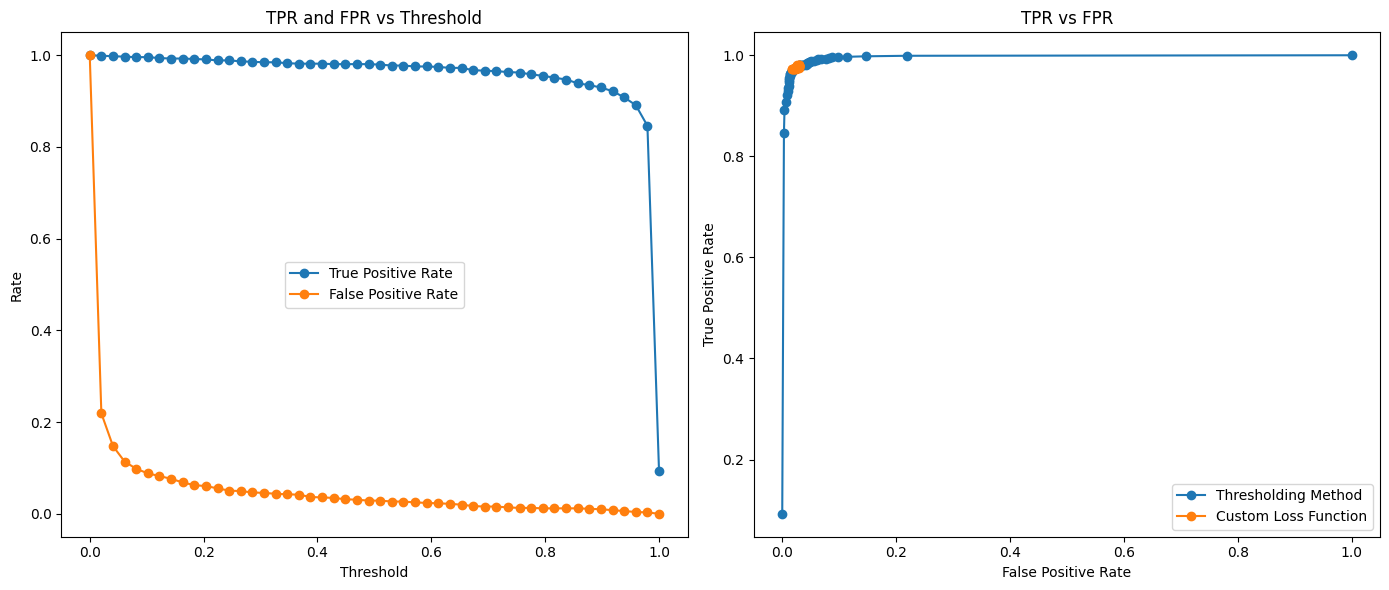

<Figure size 640x480 with 0 Axes>

In [453]:
# Plot TPR vs FPR for thresholding method
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(thresholds, tpr_threshold, label='True Positive Rate', marker='o')
plt.plot(thresholds, fpr_threshold, label='False Positive Rate', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs Threshold')
plt.legend()

# Plot TPR vs FPR for thresholding method and compare with previous method
plt.subplot(1, 2, 2)
plt.plot(fpr_threshold, tpr_threshold, label='Thresholding Method', marker='o')
plt.plot(res_df['fpr'], res_df['tpr'], label='Custom Loss Function', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TPR vs FPR')
plt.legend()

plt.tight_layout()
plt.show()

# Export plot to file
plt.savefig('tpr_fpr_vs_threshold.png')

### Comments

TODO

# Problem 4: Custom Regularization

In [204]:
import numpy as np
import pandas as pd
%pylab inline

# many of these to be removed
# necessary imports here
import tensorflow as tf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [205]:
np.random.seed(24)
n_points = 2048

x = np.vstack([np.random.randn(n_points) + ii for ii in np.arange(-3, 3)]).T
real_coefs = np.array([1.4, 0.9, .1, -3, 2.2, -1.3])
y = x.dot(real_coefs) + .5 * np.random.randn(n_points)

print(x.shape, y.shape)

(2048, 6) (2048,)


Text(0, 0.5, 'counts')

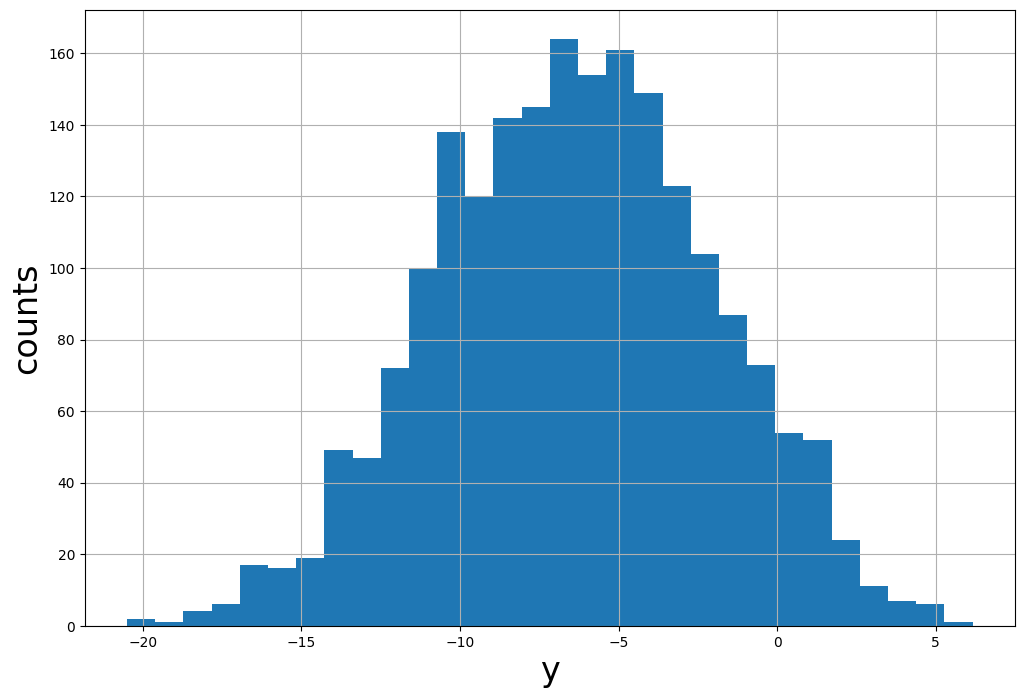

In [206]:
pd.Series(y).hist(bins=30, figsize=(12,8))
plt.xlabel('y', fontsize=24)
plt.ylabel('counts', fontsize=24)

## A new regularization
Sometimes, in the social science and in low-data situations a good rule of thumb is that instead of doing linear regression to find the coefficients, we can assume that all the coefficients are the same!

We will implement a variation on this by penalizing the `variance` of the coefficients, instead of the size.

__NOTE__: this is not a good thing to do in this situation- we have coefficients of different sign!

In this problem we will first solve linear regression with keras. Then we will add a custom regularizer to penalize the variance, and see what the effects are.

# $ \\ $
# $ \\ $
## Part 0: Solve the problem with no regularization
Steps:
 - Partition the data into train/test
 - Fit linear regression in keras with no regularization
 - Find the `mse` for the test set this model
 - Examine the coefficients and make sure they look correct

In [207]:
# partition the data
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=104, test_size=0.20, shuffle=True) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1638, 6) (410, 6) (1638,) (410,)


In [208]:
# Define the model
keras_lin_var = Sequential()
inputs = Input(shape=(X_train.shape[1],))
keras_lin_var.add(inputs)
keras_lin_var.add(Dense(1, activation='linear'))
keras_lin_var.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [209]:
# Compile the model
keras_lin_var.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the model
history = keras_lin_var.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the test set
y_pred_keras_var = keras_lin_var.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


In [210]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error
mse_keras = mean_squared_error(y_test, y_pred_keras_var)
print(f"Mean Squared Error (Keras): {mse_keras}")

Mean Squared Error (Keras): 0.26685241032771295


In [211]:
# examine coefs and make sure they look right
# Get the coefficients from the Keras model
keras_coefs_var = keras_lin_var.layers[0].get_weights()[0].flatten()

# Compare the coefficients
comparison_df = pd.DataFrame({
    'Real Coefficients': real_coefs,
    'Keras Variance Coefficients': keras_coefs_var
})

print(comparison_df)

   Real Coefficients  Keras Variance Coefficients
0                1.4                     1.334880
1                0.9                     0.876159
2                0.1                     0.101538
3               -3.0                    -2.901945
4                2.2                     2.189294
5               -1.3                    -1.288228


## Part 1: Add Regularization
Steps:
 - Make a function that given a `weight_factor` returns a well-formed keras regularization function that penalizes the variance of coefficients by this factor.
 - Fit a model with this regularizer with a `weight_factor` of `1.0`.
 - Calculate the `mse` on the test set and examine the coefficients.

__Note__: the coefficients should be closer together. Are they?


In [219]:
class VarianceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight_factor):
        self.weight_factor = weight_factor

    def __call__(self, x):
        variance = tf.math.reduce_variance(x)
        return self.weight_factor * variance

    def get_config(self):
        return {'weight_factor': self.weight_factor}

# Define the model with custom regularizer
variance_regularizer = VarianceRegularizer(weight_factor=1.0)

In [220]:
# Define the model with custom regularizer
keras_lin_var_reg = Sequential()
inputs = Input(shape=(X_train.shape[1],))
keras_lin_var_reg.add(inputs)
keras_lin_var_reg.add(Dense(1, activation='linear', kernel_regularizer=variance_regularizer))

# Compile the model
keras_lin_var_reg.compile(optimizer=Adam(), loss='mean_squared_error')

# Display the model summary
keras_lin_var_reg.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [223]:
# Fit the model
history = keras_lin_var_reg.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the test set
y_pred_keras_var_reg = keras_lin_var_reg.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step


In [224]:
# examine coefs
# Get the coefficients from the Keras model
keras_coefs_var_reg = keras_lin_var_reg.layers[0].get_weights()[0].flatten()

# Compare the coefficients
comparison_df = pd.DataFrame({
    'Real Coefficients': real_coefs,
    'Keras Variance Coefficients': keras_coefs_var_reg
})

print(comparison_df)

   Real Coefficients  Keras Variance Coefficients
0                1.4                     1.218401
1                0.9                     0.793975
2                0.1                     0.099619
3               -3.0                    -2.572428
4                2.2                     1.898584
5               -1.3                    -1.141525


In [226]:
# calculate MSE
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error
mse_keras = mean_squared_error(y_test, y_pred_keras_var_reg)
print(f"Mean Squared Error (Keras): {mse_keras}")

Mean Squared Error (Keras): 0.5788710640894891


## Part 2: Turn up the Regularization
Steps
 - Repeat part 1 with the weight factor turned up to many times its initial value
 - Calculate the `mse` on the test set
 - Examine the coefficients and comment
 - Compare these results to the best constant guess for `y`.

In [229]:
K.clear_session()
# make and fit a model with MUCH more regularization
# Define the model with custom regularizer
variance_regularizer_big = VarianceRegularizer(weight_factor=1000.0)

# Define the model with custom regularizer
keras_lin_var_reg_big = Sequential()
inputs = Input(shape=(X_train.shape[1],))
keras_lin_var_reg_big.add(inputs)
keras_lin_var_reg_big.add(Dense(1, activation='linear', kernel_regularizer=variance_regularizer_big))

# Compile the model
keras_lin_var_reg_big.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the model
history = keras_lin_var_reg_big.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the test set
y_pred_keras_var_reg_big = keras_lin_var_reg_big.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


In [230]:
# look at the coefs
# Get the coefficients from the Keras model
keras_coefs_var_reg_big = keras_lin_var_reg_big.layers[0].get_weights()[0].flatten()

# Compare the coefficients
comparison_df = pd.DataFrame({
    'Real Coefficients': real_coefs,
    'Keras Variance Coefficients': keras_coefs_var_reg_big
})

print(comparison_df)

   Real Coefficients  Keras Variance Coefficients
0                1.4                     0.500900
1                0.9                     0.491923
2                0.1                     0.481724
3               -3.0                     0.457612
4                2.2                     0.485397
5               -1.3                     0.457328


In [231]:
# calculate MSE
# calculate MSE
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error
mse_keras = mean_squared_error(y_test, y_pred_keras_var_reg_big)
print(f"Mean Squared Error (Keras): {mse_keras}")

Mean Squared Error (Keras): 18.77022199909825


## This is not bad.
 - What would the MSE of the best CONSTANT guess for `y`?

In [233]:
# Calculate the mean of y
y_mean = np.mean(y)

# Create constant array
y_constant = np.full_like(y, y_mean)

# Calculate the MSE for the constant guess
mse_constant = mean_squared_error(y, y_constant)

print(f"Mean Squared Error of the best constant guess for y: {mse_constant}")

Mean Squared Error of the best constant guess for y: 18.74503907572611


## Comments

TO DO